## 2. Preprocessing: manual annotation

In [2]:
import ipympl

import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from colicycle.MoMAobj import Momaobj
import colicycle.time_mat_operations as tmo
import colicycle.momaprocess as mp


import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual, Select, SelectMultiple, IntRangeSlider, VBox, IntSlider, FloatRangeSlider

from matplotlib.widgets import RectangleSelector
from IPython.display import display
from IPython.display import clear_output

In [3]:
%matplotlib notebook

In [4]:
folder_prefix = '../PreProcessed/'

In [5]:
######set experiment to work on######
tosave_folder = folder_prefix


######set experiment to work on######
data_folder = folder_prefix+'20180709_GW296_glucose8aa37_1_MMStack/'
#data_folder = folder_prefix+'20180711_GW296_glucose37_1_MMStack/'
#data_folder = folder_prefix+'20180706_GW296_glycerol37_1_MMStack/'



In [6]:
#load lane information 
mom = Momaobj(data_folder=data_folder,col_nb=2, no_raw=True)
#recover experiment name
current_name = data_folder.split('/')[np.argwhere([re.findall('^[0-9]{8,9}', x) for x in data_folder.split('/')])[0][0]]

In [7]:
#recover position and lane indices
ind = np.lexsort((np.array(mom.gl_list).astype('int'),np.array(mom.pos_list).astype('int')))
mom.pos_list = np.array(mom.pos_list)[ind]
mom.gl_list = np.array(mom.gl_list)[ind]

In [8]:
print('List of growth lanes and positions')
print(mom.gl_list)
print(mom.pos_list)

List of growth lanes and positions
['01' '02' '06' '07' '09' '10' '11' '13' '15' '16' '18' '19' '20' '22'
 '23' '24' '25' '26']
['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0']


In [9]:
#select as specific growth lane and position
mom.pos = mom.pos_list[2]
mom.gl = mom.gl_list[2]

In [10]:
#load segmentation
time_mat_pd = pd.read_pickle(data_folder+'/step1/step1_time_mat_pos'+mom.pos+'_GL'+mom.gl+'.pkl')

In [11]:
#set limits
time_limit = 40

first_point = time_mat_pd[time_mat_pd.born>time_limit].index[0]

<IPython.core.display.Javascript object>


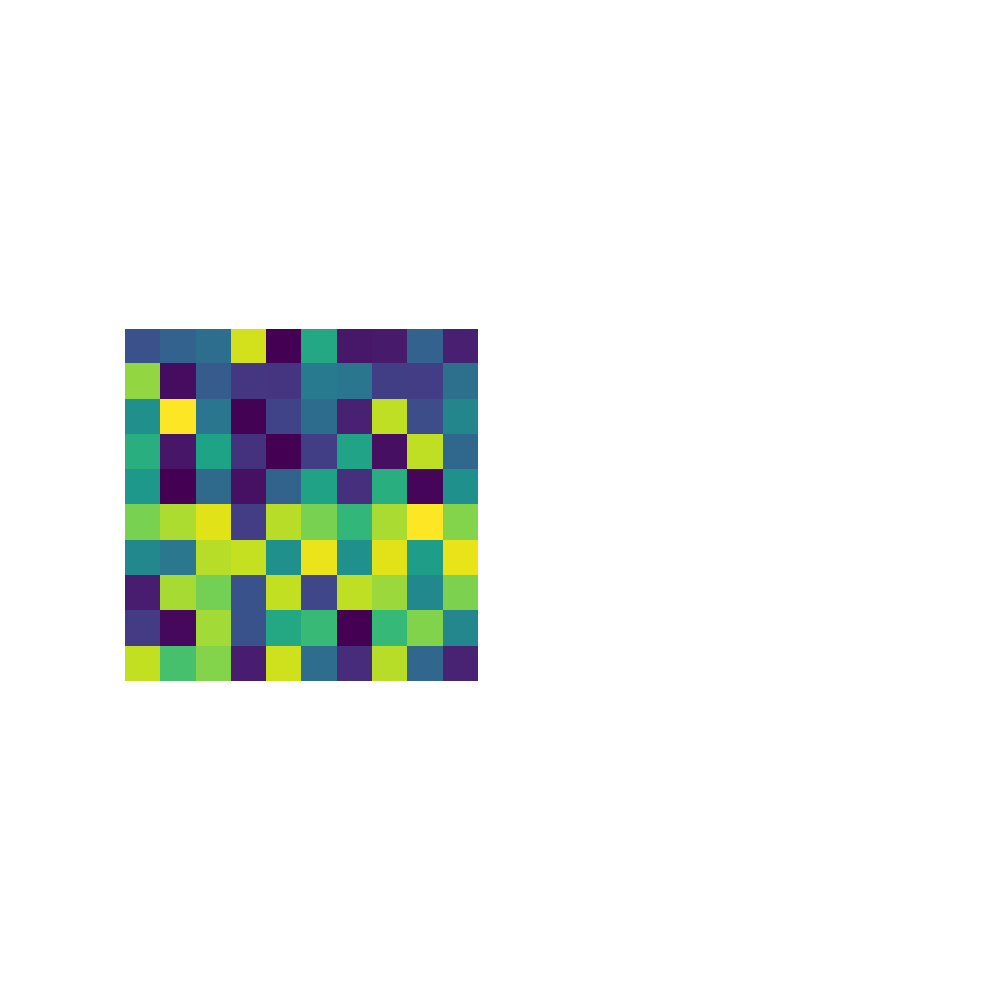

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax = plt.imshow(np.random.rand(10,10))
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


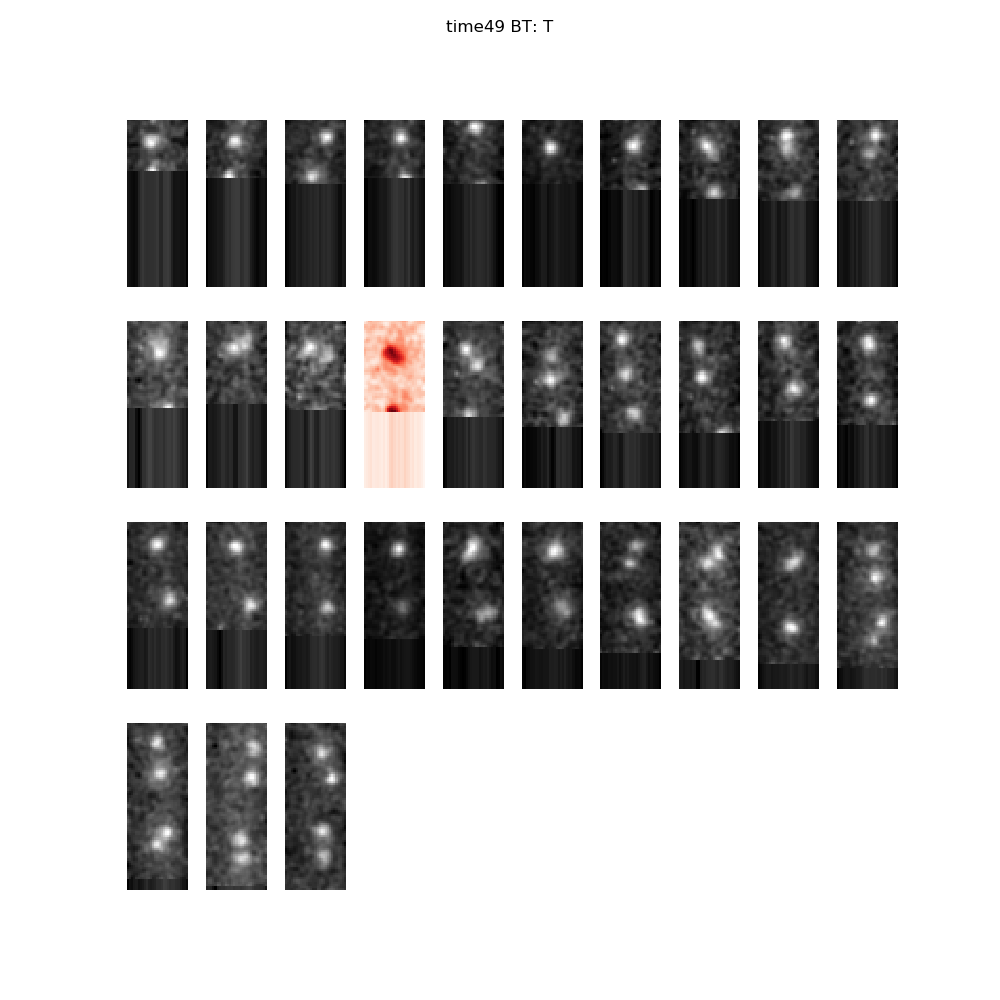

42
30


In [16]:
temp_dict = {}
for x in time_mat_pd.index:
    temp_dict[x] = {'coord':[],'birth':np.nan}
    if time_mat_pd.at[x,'mother_id']>0:
        temp_dict[x]['birth'] = len(time_mat_pd.loc[time_mat_pd.at[x,'mother_id']].length)
cols = 10
    
class Kymobuilder:
    def __init__(self, fig):
        self.time = first_point
        self.fig = fig
        
        self.birth = 0
        self.bottomtop = 'B'
                
        self.kymo,self.birth,self.bottomtop,self.allim = double_gen_kymo(self.time, time_mat_pd, mom, time_limit)
        #temp_dict[self.time]['birth'] = self.birth
        
        self.xs = []#list(line.get_xdata())
        self.shift_is_held = False
        self.ctrl_is_held = False
        
        self.fig.clear()
        rows = int(np.floor(len(self.allim)/cols))+1
        allaxes = []
        allimdata = []
        for i in range(len(self.allim)):
            ax = fig.add_subplot(rows,cols,i+1)
            if len(self.xs)>0:
                if self.xs[0]+self.birth == i:
                    im = ax.imshow(self.allim[i],cmap= 'Reds')
                else:
                    im = ax.imshow(self.allim[i],cmap = 'gray')
            else:
                im = ax.imshow(self.allim[i],cmap = 'gray')
            plt.axis('off')
            allaxes.append(ax)
            allimdata.append(im)
        allaxes = np.array(allaxes)
        fig.suptitle('time'+str(self.time)+' BT: '+self.bottomtop)
        self.fig.canvas.draw()
        
        self.allaxes = allaxes
        self.allimdata = allimdata
    
    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.fig.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidshifton = self.fig.canvas.mpl_connect(
            'key_press_event', self.on_key_press)
        self.cidshiftoff = self.fig.canvas.mpl_connect(
            'key_release_event', self.on_key_release)
        
    
    def on_press(self, event):
        
        if self.ctrl_is_held==True:
            
            if mom.col == 1:
                mom.col=2
            else:
                mom.col=1
            self.kymo,self.birth,self.bottomtop,self.allim = double_gen_kymo(self.time, time_mat_pd, mom, time_limit)
            self.fig.clear()
            rows = int(np.floor(len(self.allim)/cols))+1
            allaxes = []
            allimdata = []
            for i in range(len(self.allim)):
                ax = fig.add_subplot(rows,cols,i+1)
                if len(self.xs)>0:
                    if self.xs[0] == i:
                        im = ax.imshow(self.allim[i],cmap= 'Reds')
                    else:
                        im = ax.imshow(self.allim[i],cmap= 'gray')
                else:
                    im = ax.imshow(self.allim[i],cmap = 'gray')
                plt.axis('off')
                allaxes.append(ax)
                allimdata.append(im)
            allaxes = np.array(allaxes)
            fig.suptitle('time'+str(self.time)+' BT: '+self.bottomtop)
            self.fig.canvas.draw()
            self.allaxes = allaxes
            self.allimdata = allimdata
            #temp_dict[self.time]['birth'] = self.birth
            
        if self.shift_is_held==True:
            self.allimdata[self.xs[0]].set_cmap('gray')
            self.xs=[]
            temp_dict[self.time]['coord'] = []
            
        else:
            self.xs.append(np.argwhere(self.allaxes == event.inaxes)[0][0])
            temp_dict[self.time]['coord'].append(int(np.argwhere(self.allaxes == event.inaxes)[0][0]))
            self.allimdata[self.xs[0]].set_cmap('Reds')
        self.fig.canvas.draw()
        
    
    def on_key_press(self,event):
        #print(event.key)
        if event.key == 'shift':
            self.shift_is_held = True
        if event.key == 'control':
            self.ctrl_is_held = True
        if (event.key == 'right') or (event.key == 'left'):
            if (event.key == 'right'):
                self.time = self.time+1
            else:
                self.time = self.time-1
                
            self.xs = temp_dict[self.time]['coord'].copy()
            
            self.kymo,self.birth,self.bottomtop,self.allim = double_gen_kymo(self.time, time_mat_pd, mom, time_limit)
            #temp_dict[self.time]['birth'] = self.birth
            
            self.fig.clear()
            rows = int(np.floor(len(self.allim)/cols))+1
            allaxes = []
            allimdata = []
            for i in range(len(self.allim)):
                ax = fig.add_subplot(rows,cols,i+1)
                if len(self.xs)>0:
                    if self.xs[0] == i:
                        im = ax.imshow(self.allim[i],cmap= 'Reds')
                    else:
                        im = ax.imshow(self.allim[i],cmap= 'gray')
                else:
                    im = ax.imshow(self.allim[i],cmap = 'gray')
                plt.axis('off')
                allaxes.append(ax)
                allimdata.append(im)
            allaxes = np.array(allaxes)
            fig.suptitle('time'+str(self.time)+' BT: '+self.bottomtop)
            self.fig.canvas.draw()
            self.allaxes = allaxes
            self.allimdata = allimdata
      
    def on_key_release(self,event):
        if event.key == 'shift':
            self.shift_is_held = False
        if event.key == 'control':
            self.ctrl_is_held = False

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.set_title('click to build line segments')
line, = ax.plot([0], [0])  # empty line
ax.imshow(np.random.rand(5,10))
ax2 = fig.add_subplot(122)
ax2.imshow(np.random.rand(10,10))
plt.axis('off')
linebuilder = Kymobuilder(fig)
linebuilder.connect()

plt.show()

In [17]:
time_mat_pd['Ti'] = np.nan
for x in temp_dict:
    if len(temp_dict[x]['coord'])>0:
        time_mat_pd.at[x,'Ti'] = temp_dict[x]['coord'][0]-temp_dict[x]['birth']

In [18]:
filename = data_folder+'step2/manual_time_mat'+'_pos'+mom.pos+'_GL'+mom.gl+'.pkl'
os.makedirs(os.path.dirname(filename), exist_ok=True)
time_mat_pd.to_pickle(filename)

## Function definitions

In [13]:
def double_gen_kymo(cellid, time_mat_pd, mom, time_lim = 1):
    
    
    motherid = time_mat_pd.at[cellid,'mother_id']
    
    print(time_mat_pd.at[cellid,'born'])
    print(time_mat_pd.at[motherid,'born'])
    
    if (time_mat_pd.at[cellid,'born']<time_lim) or (time_mat_pd.at[motherid,'born']<time_lim) or (not time_mat_pd.at[cellid,'full_cellcycle']):
        return np.zeros((5,5)),1,'N',[np.zeros((5,5)),np.zeros((5,5))]
    #cellid = 90
    time_mat_pd2 = time_mat_pd.copy()
    
    kymo1, all_images_1, all_images_1b = kymo(time_mat_pd2, cellid,mom)
    kymo2, all_images_2, all_images_2b = kymo(time_mat_pd2, motherid,mom)
    
    if time_mat_pd2.at[cellid,'genealogy'][-1]=='B':
        #kymo2 = kymo2[int(kymo2.shape[0]/2)::,:]
        for i in range(len(all_images_2)):
            all_images_2[i] = all_images_2[i][int(all_images_2[i].shape[0]*(1/3))::,:]
    else:
        #kymo2 = kymo2[0:int(kymo2.shape[0]/2),:]
        for i in range(len(all_images_2)):
            all_images_2[i] = all_images_2[i][0:int(all_images_2[i].shape[0]*(2/3)),:]
        
    #proj_time = [kymo2[kymo2[:,x]>0,x] for x in range(kymo2.shape[1])]
    #proj_time = np.concatenate((proj_time,[kymo1[kymo1[:,x]>0,x] for x in range(kymo1.shape[1])]))
    
    '''maxlen = max([k.shape[0] for k in proj_time])
    kymo_tot = np.zeros((maxlen,len(proj_time)))
    kymo_tot[:] = np.NAN
    im_middle = int((kymo_tot.shape[0]-1)/2)
    for k in range(len(proj_time)):
        cur_len = len(proj_time[k])
        if np.mod(cur_len,2):
            kymo_tot[im_middle-int(cur_len/2):im_middle+int(cur_len/2)+1,k] = proj_time[k]
        else:
            kymo_tot[im_middle-int((cur_len+1)/2)+1:im_middle+int((cur_len+1)/2)+1,k] = proj_time[k]'''
    
    all_images = all_images_2+all_images_1
    
    maxrows = np.max([x.shape[0] for x in all_images])
    for i in range(len(all_images)):
        if time_mat_pd2.at[cellid,'genealogy'][-1]=='B':
            all_images[i] = np.pad(all_images[i],((maxrows-all_images[i].shape[0],0),(0,0)),mode = 'minimum')
        else:
            all_images[i] = np.pad(all_images[i],((0,maxrows-all_images[i].shape[0]),(0,0)),mode = 'minimum')
    
    kymo_tot = np.zeros((5,5))
    kymo2 = np.zeros((5,5))
    

    return kymo_tot, kymo2.shape[1], time_mat_pd2.at[cellid,'genealogy'][-1], all_images


In [14]:
import skimage.filters

def kymo(time_mat_pd,ind, mom):
    
    width = 14
    c = ind
    
    motherid = time_mat_pd.at[c,'mother_id']

    all_images = []
    all_images2 = []
    
    if 1==3:
        truc=1
    else:
        proj_time = {}
        times = [x+time_mat_pd.at[c,'born'] for x in range(time_mat_pd.at[c,'pixlim'].shape[0])]
        for t in range(len(times)):
            
            mom.time=times[t]
            im_fluo = mom.load_moma_im()
            im_fluo = im_fluo+np.min(im_fluo)
            im_fluo = im_fluo/np.max(im_fluo)
            
            im_size = im_fluo.shape
            im_middle = int((im_size[1]-1)/2)
            
            index1 = time_mat_pd.at[c,'pixlim'][t,0]+time_mat_pd.at[c,'tracklim']+1-5
            index2 = time_mat_pd.at[c,'pixlim'][t,1]+time_mat_pd.at[c,'tracklim']-1+5
            
            im_cutout = im_fluo[index1:index2,im_middle-width:im_middle+width+1]
            im_cutout = skimage.filters.gaussian(im_cutout,1)

            #proj_time[t] = np.sum(im_cutout,axis=1)
            all_images.append(im_cutout)

        
        kymo = np.zeros((10,10))

        
    return kymo, all_images, all_images2